# 인물 사진을 만들어 보자

**인물 아웃포커싱 사진**

In [ ]:
! mkdir -p content/work/human_segmentation/models
! mkdir -p content/work/human_segmentation/images
! ln -s /content/data/* /content/work/human_segmentation/images/

ln: failed to create symbolic link '/content/work/human_segmentation/images/': No such file or directory


In [ ]:
! pip install opencv-python pixellib

In [ ]:
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [ ]:
# 이미지 읽기

base_dir = "/content"
img_path = os.path.join(
    base_dir,
    "content/work/human_segmentation/images/my_image.png"
)
img_orig = cv2.imread(img_path)


In [ ]:
print(f"이미지 크기: {img_orig.shape}")


이미지 크기: (808, 538, 3)


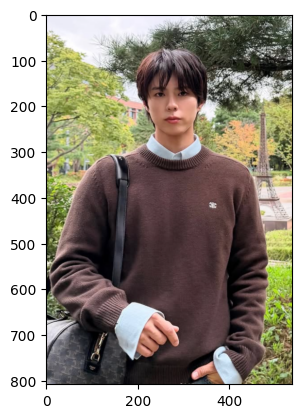

In [ ]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

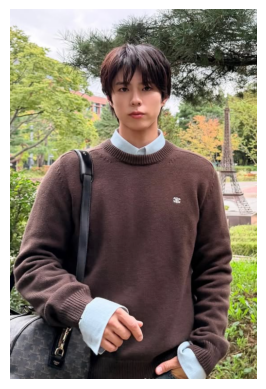

In [ ]:
img_path = "/content/content/work/human_segmentation/images/my_image.png"

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")   # 좌표축 제거
plt.show()

In [ ]:
model = deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 이미지 처리 인공지능 모델 중 사전 학습된 모델은 모델의 전처리 방식과 입력 크기 등이 사전 학습에 사용한 것과 동일하게 사용

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((808, 538)),  # 모델 입력 크기
    T.ToTensor(),
])

In [ ]:
# 전처리 코드를 이용해 사용 이미지 전처리
# 사용할 DeepLab 모델을 비롯해 인공지능 모델 중 여러 데이터를 동시에(batch) 처리하는 것을 상정하는 경우 배치(batch) 차원을 추가해주어야 함

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [ ]:
# 모델에 대한 이미지 입력

%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 17.2 s, sys: 1 s, total: 18.2 s
Wall time: 22.2 s


In [ ]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

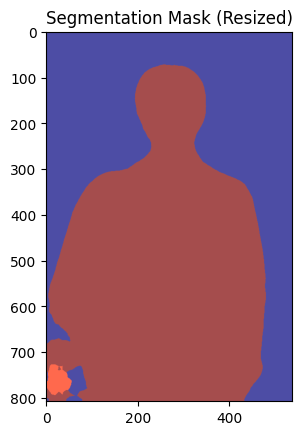

In [ ]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [ ]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 13, 15], dtype=uint8)

In [ ]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
horse
person


In [ ]:
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

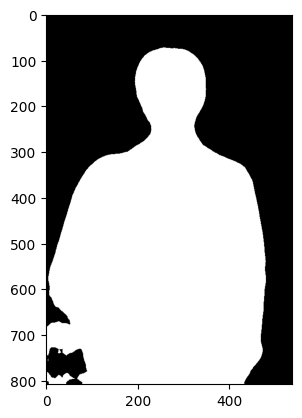

In [ ]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

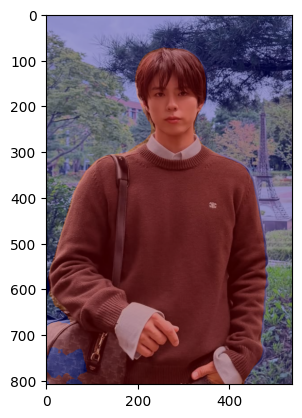

In [ ]:
# 원본 이미지와 마스트를 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

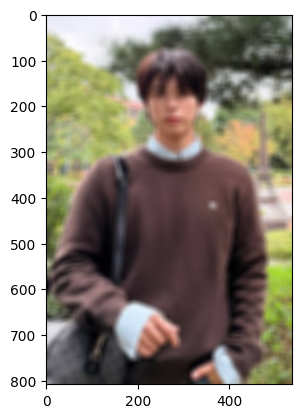

In [ ]:
# (15,15)은 blurring kernel size를 의미

img_orig_blur = cv2.blur(img_orig, (15, 15))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

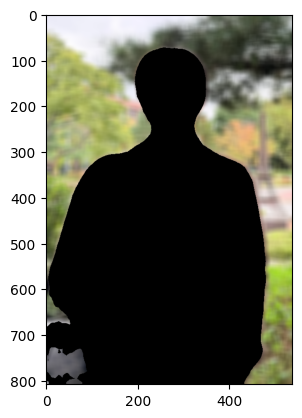

In [ ]:
# 흐려진 이미지에서 세크멘테이션 마스크를 이용해서 배경만 추출

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전
# 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0

img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있음
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

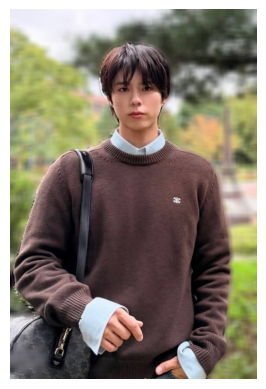

In [ ]:
# 흐린 배경과 원본 영상 합성

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis("off")   # 좌표축 제거
plt.show()

**문제점**
*   사진상 왼쪽에 착용하고 있는 가방의 일부(좌측 최하단부분)가 배경으로 인식하여 아웃포커싱 처리되었음

**해결방안**

*   segmentation mask에서 사람 영역을 조금 넓혀서 가방까지 포함되도록 처리 필요
(Morphological dilation 사용 : kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
person_mask_dilated = cv2.dilate(person_mask, kernel, iterations=1))(참고 : Chat-GPT)
*   수동으로 blur 강도를 낮추춰서 가방영역은 배경으로 인식하지 않게 해서 아웃포커싱이 되지 않도록 조치



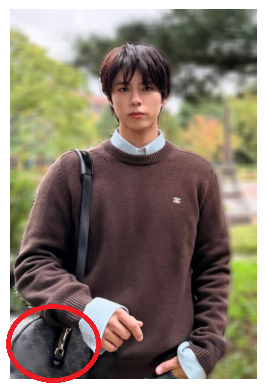

**인물사진 실험**

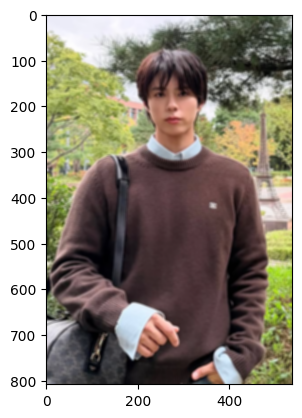

In [ ]:
#실험1

# blurring kernel size를 기존 (15, 15)에서 (6, 6)으로 조정

img_orig_blur = cv2.blur(img_orig, (6, 6))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 실험2

# Morphological dilation(형태 확장)을 사용하여 인물 마스크의 영역 확장

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
img_mask_dilated = cv2.dilate(img_mask, kernel, iterations=1)

img_mask_blur = cv2.GaussianBlur(img_mask, (21, 21), 0)

**실험결과**
*   실험 1에서 blurring kernel size를 기존 (15, 15)에서 (6, 6)으로 조정하였으나, 가방과 함께 배경도 함께 조정 아웃포커싱 효과 감소
*   실험 2를 적용할 경우 고해상도 사진에서 커널 수 조정만으로 효과 미비

**동물 아웃포커싱 사진**

In [ ]:
# 이미지 읽기

base_dir = "/content"
img_path = os.path.join(
    base_dir,
    "content/work/human_segmentation/images/shiba.jpg"
)
img_orig = cv2.imread(img_path)

In [ ]:
print(f"이미지 크기: {img_orig.shape}")

이미지 크기: (2197, 3082, 3)


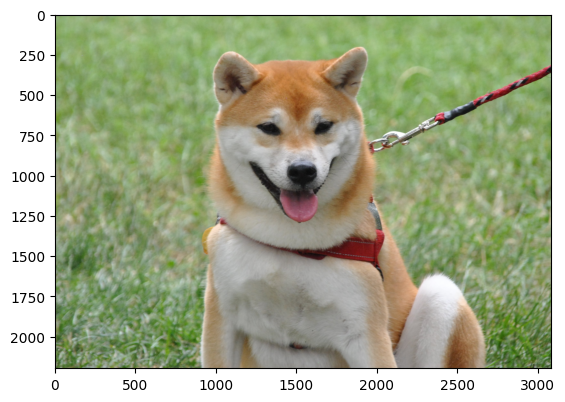

In [ ]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

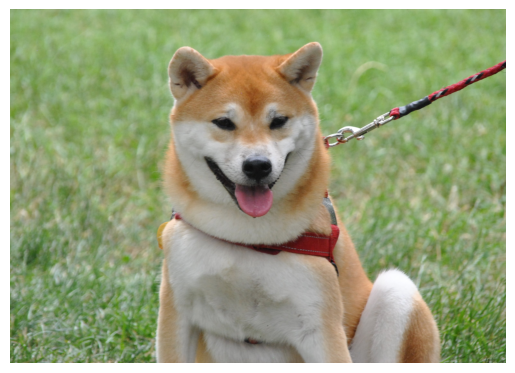

In [ ]:
img_path = "/content/content/work/human_segmentation/images/shiba.jpg"

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")   # 좌표축 제거
plt.show()

In [ ]:
model = deeplabv3_resnet101(pretrained=True).eval()

In [ ]:
# 이미지 처리 인공지능 모델 중 사전 학습된 모델은 모델의 전처리 방식과 입력 크기 등이 사전 학습에 사용한 것과 동일하게 사용

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((500, 500)),  # 모델 입력 크기
    T.ToTensor(),
])

In [ ]:
# 전처리 코드를 이용해 사용 이미지 전처리
# 사용할 DeepLab 모델을 비롯해 인공지능 모델 중 여러 데이터를 동시에(batch) 처리하는 것을 상정하는 경우 배치(batch) 차원을 추가해주어야 함

input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [ ]:
# 모델에 대한 이미지 입력

%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 9.16 s, sys: 166 ms, total: 9.33 s
Wall time: 9.41 s


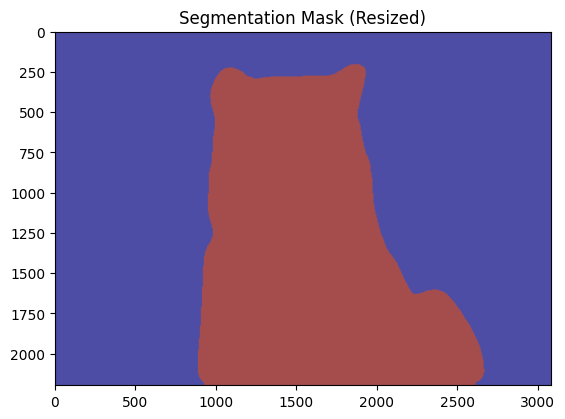

In [ ]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [ ]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 12], dtype=uint8)

In [ ]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
dog


In [ ]:
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

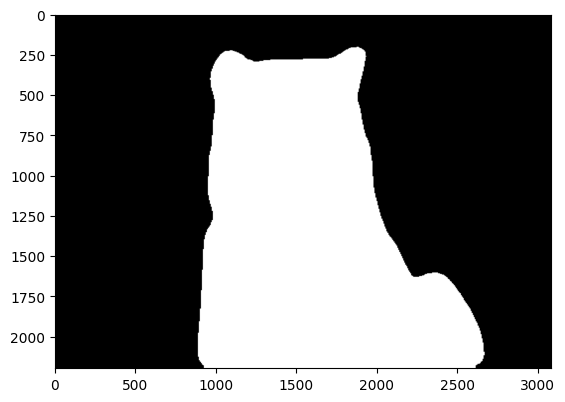

In [ ]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 12)  # 클래스 ID 12 (시바견)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

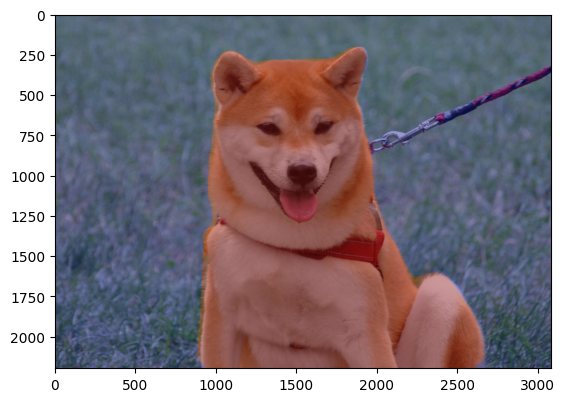

In [ ]:
# 원본 이미지와 마스트를 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

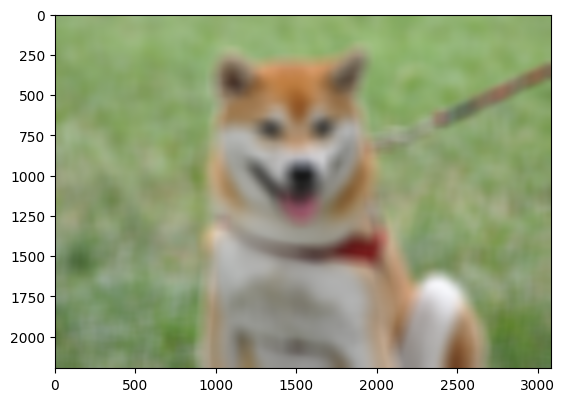

In [ ]:
# (100,100)은 blurring kernel size를 의미

img_orig_blur = cv2.blur(img_orig, (100, 100))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

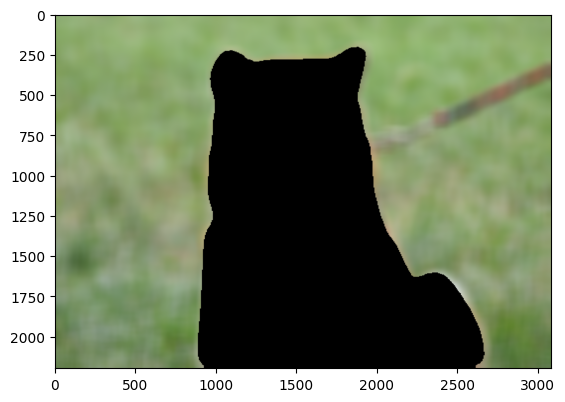

In [ ]:
# 흐려진 이미지에서 세크멘테이션 마스크를 이용해서 배경만 추출

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전
# 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0

img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있음
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

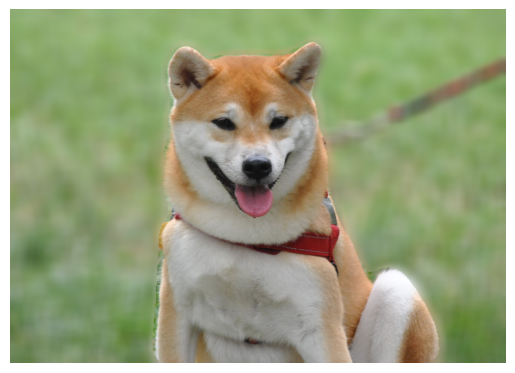

In [ ]:
# 흐린 배경과 원본 영상 합성

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis("off")   # 좌표축 제거
plt.show()

**문제점**
*   배경과 시바견의 경계가 매끄럽지 못하여 배경이 모두 깔끔하게 Blur 처리가 안되었음
*   경계가 울퉁불퉁하고 일부는 깨져 보임
*   시바견 줄을 배경으로 인식하지 않고 시바견의 일부로 인식해야 할 경우 경계처리 방안 필요

**해결방안**
*   Resize시 보간하여 계단처럼 보이는 현상 최소화
(img_mask = cv2.resize(
    img_mask,
    (w, h),
    interpolation=cv2.INTER_NEAREST
))
*   거리기반 강도 설정(foreground 근처 blur 강도를 낮품 → Depth-aware blur 개념)
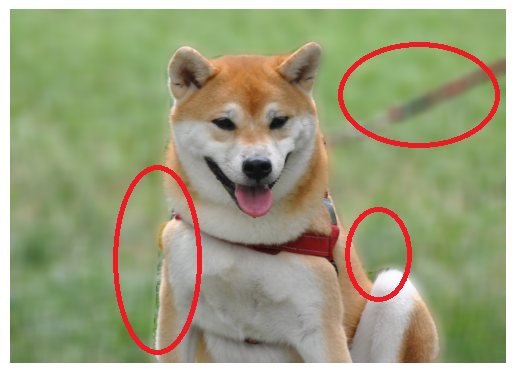

In [ ]:
#실험

#Foreground mask 준비

# img_mask: foreground = 255, background = 0
fg_mask = img_mask.copy()
bg_mask = cv2.bitwise_not(fg_mask)

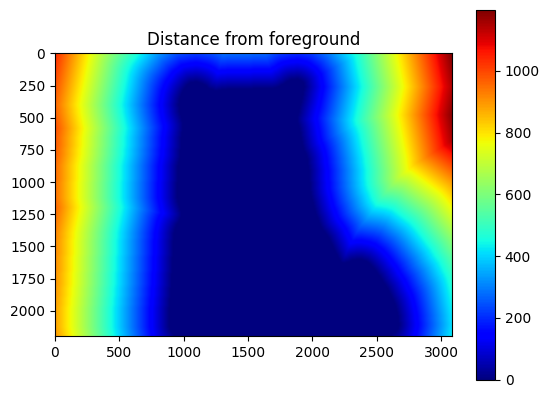

In [ ]:
#Distance Transform

# background 기준 distance 계산
dist_map = cv2.distanceTransform(
    bg_mask,
    distanceType=cv2.DIST_L2,
    maskSize=5
)

# 시각화 (확인용)
plt.imshow(dist_map, cmap="jet")
plt.colorbar()
plt.title("Distance from foreground")
plt.show()


In [ ]:
dist_norm = cv2.normalize(
    dist_map, None, 0.0, 1.0, cv2.NORM_MINMAX
)


In [ ]:
blur_light  = cv2.GaussianBlur(img_orig, (21, 21), 0)
blur_medium = cv2.GaussianBlur(img_orig, (51, 51), 0)
blur_heavy  = cv2.GaussianBlur(img_orig, (101, 101), 0)


In [ ]:
h, w = dist_norm.shape
result = img_orig.copy().astype(np.float32)

for y in range(h):
    for x in range(w):
        if fg_mask[y, x] == 255:
            continue  # foreground는 그대로 유지

        d = dist_norm[y, x]

        if d < 0.33:
            result[y, x] = blur_light[y, x]
        elif d < 0.66:
            result[y, x] = blur_medium[y, x]
        else:
            result[y, x] = blur_heavy[y, x]

result = result.astype(np.uint8)


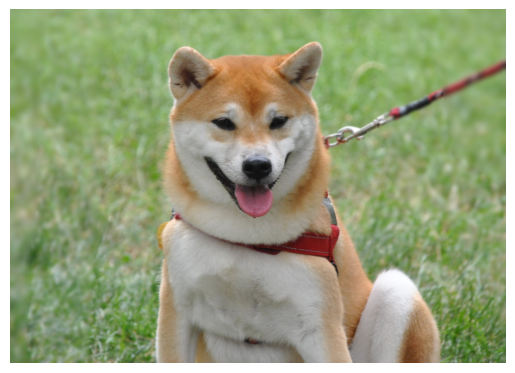

In [ ]:
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


**실험결과**


*   시바견과 배경 잔디 사이 매끄럽지 못한 경계가 개선되어 품질이 향상
*   필요시 거리강도 조절 가능



**배경전환 크로마키 사진**

원본 시바견 이미지 크기: (2197, 3082, 3)
배경 이미지 크기: (512, 910, 3)


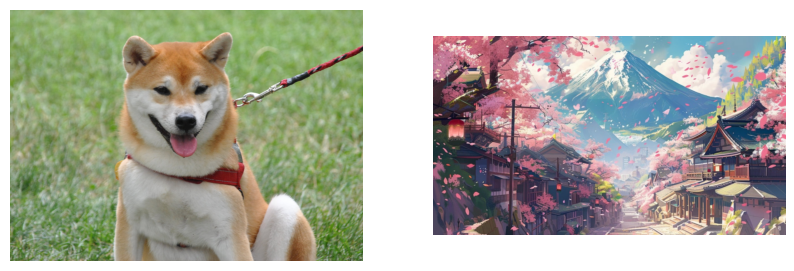

In [ ]:
shiba_img_path = "/content/content/work/human_segmentation/images/shiba.jpg"  # 시바견 이미지
background_img_path = "/content/content/work/human_segmentation/images/background.jpg"  # 일본 배경

shiba_img = cv2.imread(shiba_img_path)
background_img = cv2.imread(sand_img_path)

shiba_img = cv2.cvtColor(shiba_img, cv2.COLOR_BGR2RGB)
background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)

print(f"원본 시바견 이미지 크기: {shiba_img.shape}")
print(f"배경 이미지 크기: {background_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(shiba_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(background_img)
plt.axis("off")

plt.show()

In [ ]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(shiba_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [ ]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (shiba_img.shape[1], shiba_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (2197, 3082)


In [ ]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0 12]


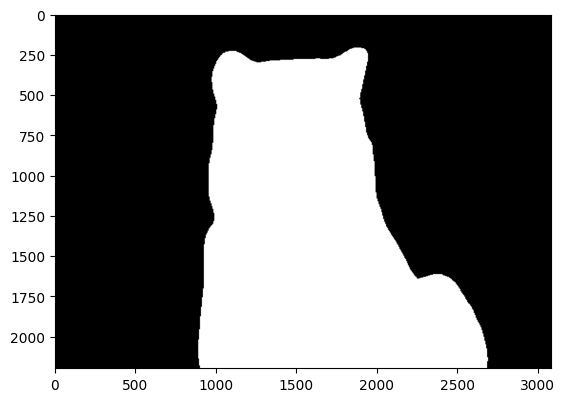

In [ ]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

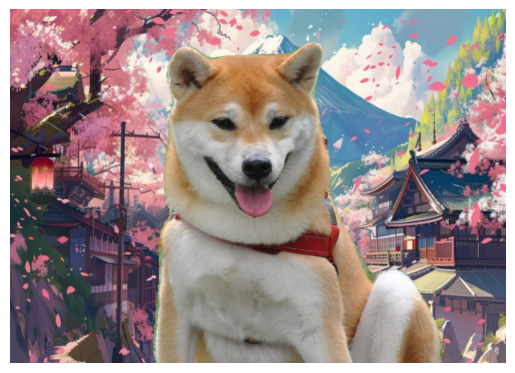

In [ ]:
# 배경을 시바견 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 시바견 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.axis("off")
plt.show()

**문제점**
*   시바견 원본 사진에서 시바견과 배경(잔디밭)의 경계를 처리하는 과정에서 배경의 일부가 시바견으로 인식(위 동물 아웃포커싱 사진 만들기와 문제 동일)
*   세그멘테이션 모델이 시바견의 털 끝과 잔디를 색 또는 텍스처가 비슷하다고 인식하는 것으로 판단됨

**해결방안**
*   Foreground 마스크를 확장하여 보정(kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
mask_fg = cv2.dilate(img_mask, kernel, iterations=1))(Chat-GPT 참고)

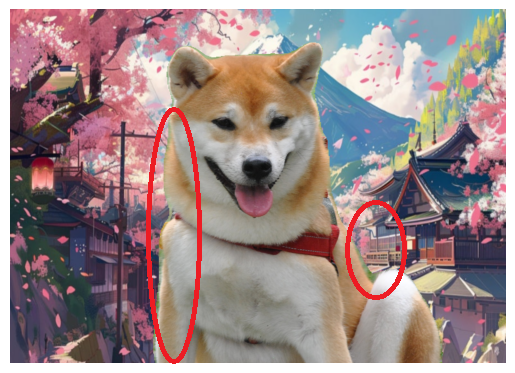
